Story:
* Giant planets around M dwarf is rare

https://docs.google.com/document/d/1ac3Ei_31-UzBYVrhJATnpB1RVMSr5qAoW6NCSSfo0bY/edit?usp=sharing

In [1]:
import json
from urllib.request import urlopen

def get_exofop_json(target_name):
    url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target_name}&json"
    print(f"Querying data from exofop:\n{url}")
    response = urlopen(url)
    data_json = json.loads(response.read())
    return data_json

In [2]:
target_name = "TOI 5671"
data_json = get_exofop_json(target_name.replace(' ', '-'))
tic_params = data_json['stellar_parameters'][1]

Querying data from exofop:
https://exofop.ipac.caltech.edu/tess/target.php?id=TOI-5671&json


In [3]:
Rs = float(tic_params['srad'])
Ms = float(tic_params['mass'])
teff = float(tic_params['teff'])
logg = float(tic_params['logg'])
Rs, Ms, teff, logg

(0.408427, 0.400962, 3380.0, 4.81894)

In [4]:
planet_params = data_json['planet_parameters'][1]
period = float(planet_params['per']) 
t0 = float(planet_params['epoch'])
t14 = float(planet_params['dur'])
period, t0, t14

(3.3079817, 2459685.753346, 1.666)

In [6]:
import astropy.units as u

from astropy.units import Quantity
from astropy.constants import G
from numpy import pi, sin, sqrt

def mp_from_kiepms(k, i, e, p, mstar):
    """Calculates the planet's mass from RV parameters.

    Parameters
    ----------
    k: float, ndarray, or Quantity
        RV semiamplitude [m/s]
    i: float, ndarray, or Quantity
        Inclination [rad]
    e: float, ndarray, or Quantity
        Eccentricity [-]
    p: float, ndarray, or Quantity
        Orbital period [d]
    mstar: float, ndarray, or Quantity
        Stellar mass [Solar mass]

    Returns
    -------
    Planet mass [M_Jup]
    """
    k = k.to(u.m/u.s) if isinstance(k, Quantity) else k * u.m/u.s
    i = i.to(u.rad) if isinstance(i, Quantity) else i*u.rad
    p = p.to(u.s) if isinstance(p, Quantity) else (p*u.day).to(u.s)
    mstar = mstar.to(u.kg) if isinstance(mstar, Quantity) else (mstar*u.M_sun).to(u.kg)
    return (k * (p/(2*pi*G)) ** (1/3) * mstar ** (2 / 3) / sin(i) * sqrt((1 - e ** 2))).to(u.M_jup).value

k_rv = 245# m/s
inc = pi/2
ecc = 0
mass = mp_from_kiepms(k_rv, inc, ecc, period, Ms)

In [ ]:
import lightkurve as lk


res = lk.search_lightcurve(target_name)
res

/home/jp/miniconda3/envs/toi5671/lib/python3.11/site-packages/lightkurve/lightcurve.py:1131: LightkurveWarning: The light curve appears to be zero-centered (median=1.00e+00 +/- 1.00e+02); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

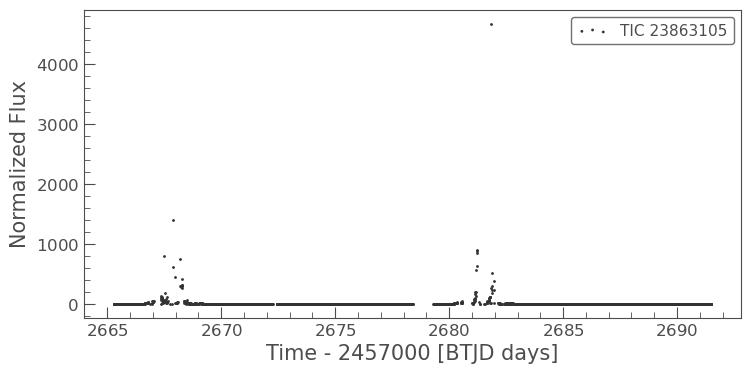

In [4]:
qlp = res[0].download().normalize()
qlp.scatter()